In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('df_mes.csv')
display(df)

,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine
0,7,0,0,0,175.60,2.0,2019-07-22 00:00:00,15,223.818631,0.0,0.000000,1.000000
1,7,0,0,0,174.91,1.8,2019-07-22 00:30:00,15,128.305934,0.0,0.130526,0.991445
2,7,0,0,0,168.63,1.7,2019-07-22 01:00:00,15,104.161072,0.0,0.258819,0.965926
3,7,0,0,0,161.86,1.8,2019-07-22 01:30:00,15,96.488681,0.0,0.382683,0.923880
4,7,0,0,0,155.01,1.8,2019-07-22 02:00:00,15,92.182515,0.0,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
5755,11,0,0,0,124.92,3.9,2019-11-18 21:30:00,60,221.848110,0.0,-0.608761,0.793353
5756,11,0,0,0,129.18,3.9,2019-11-18 22:00:00,15,214.765982,0.0,-0.500000,0.866025
5757,11,0,0,0,132.69,3.9,2019-11-18 22:30:00,15,206.627335,0.0,-0.382683,0.923880
5758,11,0,0,0,135.28,3.8,2019-11-18 23:00:00,15,197.464342,0.0,-0.258819,0.965926


Divisão do algoritmo nos períodos de backtracking (5:30-7:30 e 15:30-17:30)

Se o ângulo ótimo for maior que do pvlib mantem-se o do pvlib 

In [3]:
import numpy as np
from datetime import time 
df['datetime'] = pd.to_datetime(df['datetime'])

#np.where(condição, valor_se_verdadeiro, valor_se_falso)
df['Angulo real'] = np.where(
    ((df['datetime'].dt.time >= time(5,30)) & (df['datetime'].dt.time <= time(7,30))) |
    ((df['datetime'].dt.time >= time(15,30)) & (df['datetime'].dt.time <= time(17,30))),
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)

,Month,DHI,DNI,GHI,Solar Zenith Angle,Wind Speed,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,Angulo real
0,7,0,0,0,175.60,2.0,2019-07-22 00:00:00,15,223.818631,0.0,0.000000,1.000000,15.0
1,7,0,0,0,174.91,1.8,2019-07-22 00:30:00,15,128.305934,0.0,0.130526,0.991445,15.0
2,7,0,0,0,168.63,1.7,2019-07-22 01:00:00,15,104.161072,0.0,0.258819,0.965926,15.0
3,7,0,0,0,161.86,1.8,2019-07-22 01:30:00,15,96.488681,0.0,0.382683,0.923880,15.0
4,7,0,0,0,155.01,1.8,2019-07-22 02:00:00,15,92.182515,0.0,0.500000,0.866025,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,11,0,0,0,124.92,3.9,2019-11-18 21:30:00,60,221.848110,0.0,-0.608761,0.793353,60.0
5756,11,0,0,0,129.18,3.9,2019-11-18 22:00:00,15,214.765982,0.0,-0.500000,0.866025,15.0
5757,11,0,0,0,132.69,3.9,2019-11-18 22:30:00,15,206.627335,0.0,-0.382683,0.923880,15.0
5758,11,0,0,0,135.28,3.8,2019-11-18 23:00:00,15,197.464342,0.0,-0.258819,0.965926,15.0


In [4]:
from sklearn.preprocessing import MinMaxScaler
# Mantem datetime e theta na divisão 
X = df[['Month','Wind Speed','Solar Zenith Angle','GHI','azimuth','Hour Sine','Hour Cosine','datetime','tracker_theta','DNI','DHI']]
#display(X)
y = df[['Angulo real']] 
#display(y)

# Shuffle preserva a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=42)
display(X_train)
display(X_test)
datetime = X_test['datetime']
display(datetime)
tracker_theta = X_test['tracker_theta']
display(tracker_theta)
dni = X_test['DNI']
dhi = X_test['DHI']
ghi = X_test['GHI']
print(X_train.columns)
print(X_test.columns)
cols = ['datetime', 'tracker_theta','DNI','DHI']
X_train = X_train.drop(columns=cols, axis=1)
display(X_train)
X_test = X_test.drop(columns=cols, axis=1)
display(X_test)


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,tracker_theta,DNI,DHI
0,7,2.0,175.60,0,223.818631,0.000000,1.000000,2019-07-22 00:00:00,0.0,0,0
1,7,1.8,174.91,0,128.305934,0.130526,0.991445,2019-07-22 00:30:00,0.0,0,0
2,7,1.7,168.63,0,104.161072,0.258819,0.965926,2019-07-22 01:00:00,0.0,0,0
3,7,1.8,161.86,0,96.488681,0.382683,0.923880,2019-07-22 01:30:00,0.0,0,0
4,7,1.8,155.01,0,92.182515,0.500000,0.866025,2019-07-22 02:00:00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4315,10,4.3,131.71,0,229.738716,-0.608761,0.793353,2019-10-19 21:30:00,0.0,0,0
4316,10,4.2,136.65,0,222.074019,-0.500000,0.866025,2019-10-19 22:00:00,0.0,0,0
4317,10,4.2,140.84,0,212.833073,-0.382683,0.923880,2019-10-19 22:30:00,0.0,0,0
4318,10,4.1,144.00,0,201.875372,-0.258819,0.965926,2019-10-19 23:00:00,0.0,0,0


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,tracker_theta,DNI,DHI
4320,10,4.1,146.18,0,176.200980,0.000000,1.000000,2019-10-20 00:00:00,0.0,0,0
4321,10,4.1,144.95,0,163.307632,0.130526,0.991445,2019-10-20 00:30:00,0.0,0,0
4322,10,4.0,142.30,0,151.668884,0.258819,0.965926,2019-10-20 01:00:00,0.0,0,0
4323,10,4.0,138.50,0,141.714010,0.382683,0.923880,2019-10-20 01:30:00,0.0,0,0
4324,10,4.1,133.85,0,133.422840,0.500000,0.866025,2019-10-20 02:00:00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5755,11,3.9,124.92,0,221.848110,-0.608761,0.793353,2019-11-18 21:30:00,0.0,0,0
5756,11,3.9,129.18,0,214.765982,-0.500000,0.866025,2019-11-18 22:00:00,0.0,0,0
5757,11,3.9,132.69,0,206.627335,-0.382683,0.923880,2019-11-18 22:30:00,0.0,0,0
5758,11,3.8,135.28,0,197.464342,-0.258819,0.965926,2019-11-18 23:00:00,0.0,0,0


4320   2019-10-20 00:00:00
4321   2019-10-20 00:30:00
4322   2019-10-20 01:00:00
4323   2019-10-20 01:30:00
4324   2019-10-20 02:00:00
               ...        
5755   2019-11-18 21:30:00
5756   2019-11-18 22:00:00
5757   2019-11-18 22:30:00
5758   2019-11-18 23:00:00
5759   2019-11-18 23:30:00
Name: datetime, Length: 1440, dtype: datetime64[ns]

4320    0.0
4321    0.0
4322    0.0
4323    0.0
4324    0.0
       ... 
5755    0.0
5756    0.0
5757    0.0
5758    0.0
5759    0.0
Name: tracker_theta, Length: 1440, dtype: float64

Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'tracker_theta', 'DNI', 'DHI'],
      dtype='object')
Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'tracker_theta', 'DNI', 'DHI'],
      dtype='object')


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
0,7,2.0,175.60,0,223.818631,0.000000,1.000000
1,7,1.8,174.91,0,128.305934,0.130526,0.991445
2,7,1.7,168.63,0,104.161072,0.258819,0.965926
3,7,1.8,161.86,0,96.488681,0.382683,0.923880
4,7,1.8,155.01,0,92.182515,0.500000,0.866025
...,...,...,...,...,...,...,...
4315,10,4.3,131.71,0,229.738716,-0.608761,0.793353
4316,10,4.2,136.65,0,222.074019,-0.500000,0.866025
4317,10,4.2,140.84,0,212.833073,-0.382683,0.923880
4318,10,4.1,144.00,0,201.875372,-0.258819,0.965926


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
4320,10,4.1,146.18,0,176.200980,0.000000,1.000000
4321,10,4.1,144.95,0,163.307632,0.130526,0.991445
4322,10,4.0,142.30,0,151.668884,0.258819,0.965926
4323,10,4.0,138.50,0,141.714010,0.382683,0.923880
4324,10,4.1,133.85,0,133.422840,0.500000,0.866025
...,...,...,...,...,...,...,...
5755,11,3.9,124.92,0,221.848110,-0.608761,0.793353
5756,11,3.9,129.18,0,214.765982,-0.500000,0.866025
5757,11,3.9,132.69,0,206.627335,-0.382683,0.923880
5758,11,3.8,135.28,0,197.464342,-0.258819,0.965926


In [5]:
# Tratamento
X_train['Month'] = X_train['Month'].replace({10: 0, 11: 1})
X_test['Month'] = X_test['Month'].replace({10: 0, 11: 1})

scaler = MinMaxScaler()
colunas = ['GHI', 'Wind Speed', 'Solar Zenith Angle','azimuth']

X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_test[colunas] = scaler.transform(X_test[colunas])

scaler_y = MinMaxScaler()
y_train['Angulo real'] = scaler_y.fit_transform(y_train[['Angulo real']])
y_test['Angulo real'] = scaler_y.transform(y_test[['Angulo real']])

#display(X_train)
#display(X_test)
#display(y_train)
#display(y_test)

In [6]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\Marina\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [7]:
import numpy as np
y_pred = rf_model.predict(X_test)
# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test[['Angulo real']])
mae = mean_absolute_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
rmse = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado, y_pred=y_pred_desnormalizado))
r2 = r2_score(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
print("Erro médio absoluto", mae)
print("Raíz do erro médio quadrático", rmse)
print ("R2", r2)

Erro médio absoluto 2.939705787214317
Raíz do erro médio quadrático 8.971808765767303
R2 0.8908813301582151


In [8]:
# .ravel transforma as colunas em unidimensionais novamente
resultados = pd.DataFrame({
    'Real': y_test_desnormalizado.ravel(),
    'Predito': y_pred_desnormalizado.ravel(),
    'Datetime':datetime,
    'Theta': tracker_theta,
    'GHI': ghi,
    'DNI': dni,
    'DHI': dhi
})
display(resultados)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI
4320,15.0,15.0,2019-10-20 00:00:00,0.0,0,0,0
4321,15.0,15.0,2019-10-20 00:30:00,0.0,0,0,0
4322,15.0,15.0,2019-10-20 01:00:00,0.0,0,0,0
4323,15.0,15.0,2019-10-20 01:30:00,0.0,0,0,0
4324,15.0,15.0,2019-10-20 02:00:00,0.0,0,0,0
...,...,...,...,...,...,...,...
5755,60.0,15.0,2019-11-18 21:30:00,0.0,0,0,0
5756,15.0,15.0,2019-11-18 22:00:00,0.0,0,0,0
5757,15.0,15.0,2019-11-18 22:30:00,0.0,0,0,0
5758,15.0,15.0,2019-11-18 23:00:00,0.0,0,0,0


In [9]:
resultados.to_csv("resultados.csv")

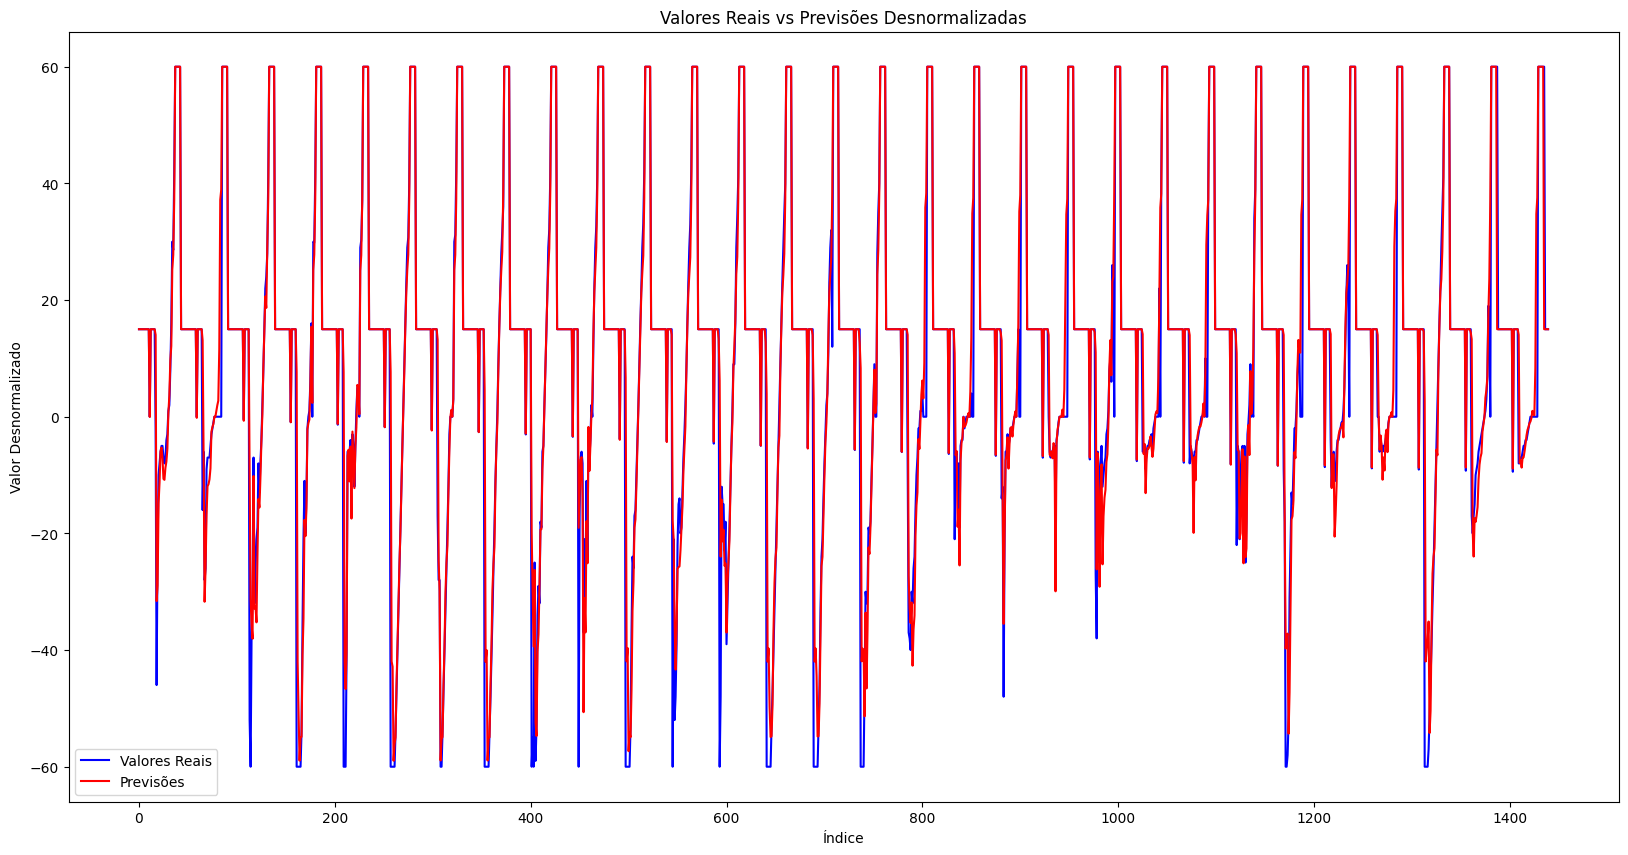

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

# Plot dos valores reais
plt.plot(y_test_desnormalizado, label='Valores Reais', color='blue')

# Plot das previsões
plt.plot(y_pred_desnormalizado, label='Previsões', color='red')

# Adiciona título e legendas
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()

# Mostrar o gráfico
plt.show()